In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import nltk
import nltk.corpus

# NLTK Libraries
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

%autosave 300

Autosaving every 300 seconds


In [2]:
datapath = './dataset/'


train = pd.read_csv(datapath + 'train.tsv', header=None, index_col=0, delimiter='\t')
val = pd.read_csv(datapath + 'val.tsv', header=None, index_col=0, delimiter='\t')
test = pd.read_csv(datapath + 'test.tsv', header=None, index_col=0, delimiter='\t')

train.head()

train.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'job title', 
                 'state info', 'party', 'bt', 'f', 'ht', 'mt', 'pof', 'context', 
                 'justification']

val.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'job title', 
                 'state info', 'party', 'bt', 'f', 'ht', 'mt', 'pof', 'context', 
                 'justification']

test.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'job title', 
                 'state info', 'party', 'bt', 'f', 'ht', 'mt', 'pof', 'context', 
                 'justification']


train.drop(['ID','job title', 'state info'], axis=1, inplace=True)
val.drop(['ID','job title', 'state info'], axis=1, inplace=True)
test.drop(['ID','job title', 'state info'], axis=1, inplace=True)

train['justification'] = train['justification'].fillna("no_text")
val['justification'] = val['justification'].fillna("no_text")
test['justification'] = test['justification'].fillna("no_text")

print(train.shape)
print(val.shape)
print(test.shape)
train.head()

(10240, 12)
(1284, 12)
(1267, 12)


,label,statement,subject,speaker,party,bt,f,ht,mt,pof,context,justification
0,,,,,,,,,,,,
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [3]:
train[train.pof.isnull()]

,label,statement,subject,speaker,party,bt,f,ht,mt,pof,context,justification
0,,,,,,,,,,,,
2142,false,The fact is that although we have had a presid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Perry says Paine wrote that the duty of a patr...
9375,false,"Joe, I keep hearing you every morning talking ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Bill Clinton said, ""As secretary of state, (Hi..."


In [4]:
train.drop([2142, 9375], axis=0, inplace=True)

In [5]:
int_lists = ["bt", "f", "ht", "mt", "pof"]

for i in int_lists:
    train[i] = train[i].astype(int)
    val[i] = val[i].astype(int)
    test[i] = test[i].astype(int)

In [8]:
# bt - Barely True, f - false,  pof- pants on fire -> Considered as false
# ht- half true, mt- mostly true, t - true -> Considered as True

print(all_data.label.unique())
Y_binary = []
# all_data.label.unique().tolist()
for i in all_data['label']:
    if i=='false' or i=='barely-true' or i=='pants-fire':
        Y_binary+=[0]
    else:
        Y_binary+=[1]

Y_six = []

for i in all_data['label']:
    if i =='pants-fire':
        Y_six+=[0]
    elif i=='false':
        Y_six+=[1]
    elif i=='barely-true':
        Y_six+=[2]
    elif i=='half-true':
        Y_six+=[3]
    elif i=='mostly-true':
        Y_six+=[4]
    else:
        Y_six+=[5]
        
# train.label.unique()
print(len(Y_binary), len(Y_six))

['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']
12789 12789


In [9]:
labels_dict = {"pants-fire":0, "false":1, "barely-true":2, "half-true":3, "mostly-true":4, 
              "true":5}
train['new_labels'] = train['label'].apply(lambda x: labels_dict[x])
val['new_labels'] = val['label'].apply(lambda x: labels_dict[x])
test['new_labels'] = test['label'].apply(lambda x: labels_dict[x])

In [53]:
all_data = pd.concat([train, val, test], ignore_index=False)
print(all_data.shape)

(12789, 13)


In [54]:
all_data.head()

,label,statement,subject,speaker,party,bt,f,ht,mt,pof,context,justification,new_labels
0,,,,,,,,,,,,,
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,0,1,0,0,0,a mailer,That's a premise that he fails to back up. Ann...,1
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,0,0,1,1,0,a floor speech.,"Surovell said the decline of coal ""started whe...",3
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,70,71,160,163,9,Denver,Obama said he would have voted against the ame...,4
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,none,7,19,3,5,44,a news release,The release may have a point that Mikulskis co...,1
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,15,9,20,19,2,an interview on CNN,"Crist said that the economic ""turnaround start...",3


In [10]:
Counter(all_data['label'])

Counter({'false': 2505,
         'half-true': 2627,
         'mostly-true': 2454,
         'true': 2053,
         'barely-true': 2103,
         'pants-fire': 1047})

In [55]:
train.info()
all_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10238 entries, 0 to 10239
Data columns (total 13 columns):
label            10238 non-null object
statement        10238 non-null object
subject          10238 non-null object
speaker          10238 non-null object
party            10238 non-null object
bt               10238 non-null int64
f                10238 non-null int64
ht               10238 non-null int64
mt               10238 non-null int64
pof              10238 non-null int64
context          10138 non-null object
justification    10238 non-null object
new_labels       10238 non-null int64
dtypes: int64(6), object(7)
memory usage: 1.1+ MB


,bt,f,ht,mt,pof,new_labels
count,12789.000000,12789.000000,12789.000000,12789.000000,12789.000000,12789.000000
mean,11.583939,13.359059,17.185785,16.497850,6.251388,2.711158
std,18.978037,24.140086,35.847678,36.165276,16.180777,1.560605
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000,3.000000
75%,12.000000,15.000000,13.000000,12.000000,5.000000,4.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000,5.000000


In [13]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = round(all_data.isnull().sum().sort_values(ascending = False)/len(all_data)*100, 2)
pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])

,Total,Percent
context,129,1.01
justification,0,0.00
pof,0,0.00
mt,0,0.00
ht,0,0.00
f,0,0.00
bt,0,0.00
party,0,0.00
speaker,0,0.00
subject,0,0.00


In [14]:
all_statements = []
all_justifications = []


for i in all_data['statement']:
    all_statements.append(i)

for line in all_data['justification']:
    all_justifications.append(line)

print(len(all_statements))
print(len(all_justifications))

12789
12789


In [15]:
print(train.columns)

Index(['label', 'statement', 'subject', 'speaker', 'party', 'bt', 'f', 'ht',
       'mt', 'pof', 'context', 'justification', 'new_labels'],
      dtype='object')


In [16]:
parties = train.party.unique().tolist()
print(parties)
print(len(parties))

['republican', 'democrat', 'none', 'organization', 'independent', 'columnist', 'activist', 'talk-show-host', 'libertarian', 'newsmaker', 'journalist', 'labor-leader', 'state-official', 'business-leader', 'education-official', 'tea-party-member', 'green', 'liberal-party-canada', 'government-body', 'Moderate', 'democratic-farmer-labor', 'ocean-state-tea-party-action', 'constitution-party']
23


In [17]:
contexts = train.context.unique().tolist()
print(len(contexts))

4346


In [18]:
# train[train.justification.isnull()]
plot_size = plt.rcParams["figure.figsize"] 

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

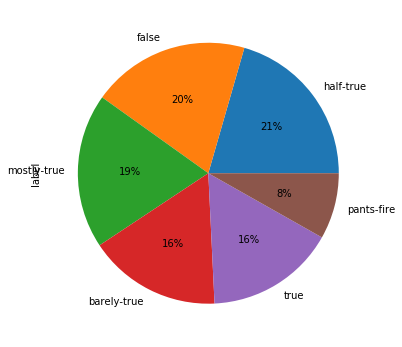

In [19]:
all_data.label.value_counts().plot(kind='pie', autopct='%1.0f%%')

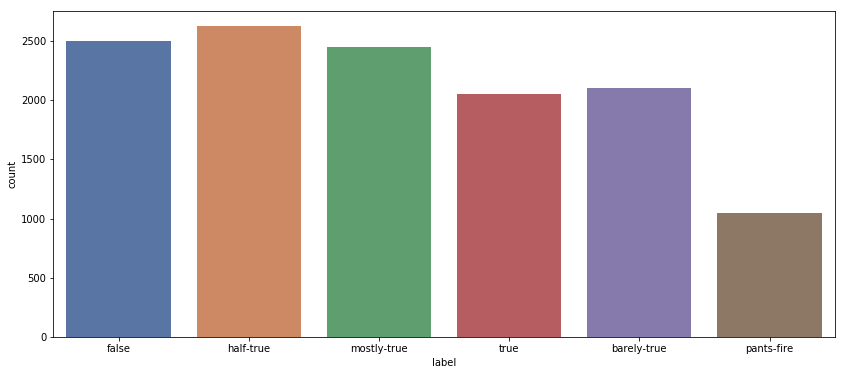

In [20]:
# fact_sentiments = all_data.groupby(['statement', 'label']).label.count().unstack()
# fact_sentiments.plot(kind='bar')
plt.figure(figsize=(14, 6))
sns.countplot(x=all_data['label'], data=all_data, palette='deep')

In [21]:
import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

statements_clean = preprocess_reviews(all_statements)
justifications_clean = preprocess_reviews(all_justifications)
# review_test_clean = preprocess_reviews(reviews_test)

In [22]:
X_train = statements_clean[:train.shape[0]]
X_val = statements_clean[train.shape[0]:train.shape[0]+val.shape[0]]
X_test = statements_clean[train.shape[0]+val.shape[0]:]
print(len(X_train), len(X_val), len(X_test))
# print(X_train)

10238 1284 1267


In [23]:
Y_train_bi = Y_binary[:train.shape[0]]
Y_val_bi = Y_binary[train.shape[0]:train.shape[0]+val.shape[0]]
Y_test_bi = Y_binary[train.shape[0]+val.shape[0]:]

Y_train_six = Y_six[:train.shape[0]]
Y_val_six = Y_six[train.shape[0]:train.shape[0]+val.shape[0]]
Y_test_six = Y_six[train.shape[0]+val.shape[0]:]

In [24]:
stop_words = ['in', 'of', 'at', 'a', 'the']

# Not using stop words

v = CountVectorizer()
v.fit(X_train)

X_train_bow = v.transform(X_train)
X_val_bow = v.transform(X_val)
X_test_bow = v.transform(X_test)

print(X_train_bow.shape)
print(X_val_bow.shape)

(10238, 11733)
(1284, 11733)


In [25]:
c = LogisticRegression(C=0.05)
c.fit(X_train_bow, Y_train_bi)

val_score = c.score(X_val_bow, Y_val_bi)
print("Val: LR:S: ", val_score)
test_score = c.score(X_test_bow, Y_test_bi)
print("Test: LR:S: ", test_score)

Val: LR:S:  0.6207165109034268
Test: LR:S:  0.6298342541436464


/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train_bow, Y_train_bi)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(Y_val_bi, lr.predict(X_val_bow))))
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(Y_test_bi, lr.predict(X_test_bow))))

Accuracy for C=0.01: 0.618380062305296
Accuracy for C=0.01: 0.6108918705603789
Accuracy for C=0.05: 0.6207165109034268
Accuracy for C=0.05: 0.6298342541436464
Accuracy for C=0.25: 0.6004672897196262
Accuracy for C=0.25: 0.6258879242304657
Accuracy for C=0.5: 0.5965732087227414
Accuracy for C=0.5: 0.6203630623520127
Accuracy for C=1: 0.5887850467289719
Accuracy for C=1: 0.6195737963693765


In [27]:
c_six = LogisticRegression(C=0.05)
c_six.fit(X_train_bow, Y_train_six)

score = c_six.score(X_val_bow, Y_val_six)
print(score)
test_score = c_six.score(X_test_bow, Y_test_six)
print(test_score)

/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.24221183800623053
0.2573007103393844


In [28]:
tf_idf = TfidfVectorizer()
tf_idf.fit(X_train)

X_train_idf = tf_idf.transform(X_train)
X_val_idf = tf_idf.transform(X_val)
X_test_idf = tf_idf.transform(X_test)

print(X_train_idf.shape)

(10238, 11733)


In [29]:
lr1 = LogisticRegression(C=0.05)
lr1.fit(X_train_idf, Y_train_bi)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
y_pred_bi = lr1.predict(X_val_idf)
print(accuracy_score(Y_val_bi, y_pred_bi))
print("F1:", f1_score(Y_val_bi, y_pred_bi))

0.5607476635514018
F1: 0.6928104575163397


In [31]:
val_score = lr1.score(X_val_idf, Y_val_bi)
print(val_score)
test_score = lr1.score(X_test_idf, Y_test_bi)
print(test_score)

0.5607476635514018
0.5872138910812944


In [32]:
lr2 = LogisticRegression(C=0.05)
lr2.fit(X_train_idf, Y_train_six)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
val_score = lr2.score(X_val_idf, Y_val_six)
print(val_score)
test_score = lr2.score(X_test_idf, Y_test_six)
print(test_score)

0.23598130841121495
0.250197316495659


In [34]:
y_pred_six = lr2.predict(X_val_bow)
print("F1:", f1_score(Y_val_six, y_pred_six, average='micro'))

F1: 0.23130841121495327


In [35]:
svm1 = SVC(C=0.05)
svm1.fit(X_train_bow, Y_train_bi)

/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.05, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [36]:
val_score= svm1.score(X_val_bow, Y_val_bi)
print(val_score)
test_score = svm1.score(X_test_bow, Y_test_bi)
print(test_score)

0.5202492211838006
0.56353591160221


In [37]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train_bow, Y_train_six)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(Y_val_six, svm.predict(X_val_bow))))

Accuracy for C=0.01: 0.23208722741433022
Accuracy for C=0.05: 0.23052959501557632
Accuracy for C=0.25: 0.22819314641744548
Accuracy for C=0.5: 0.23442367601246106
Accuracy for C=1: 0.2398753894080997


/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [38]:
s_j_clean = []

for i in range(len(all_statements)):
    s_j_clean += [statements_clean[i] +SPACE +  justifications_clean[i]]

print(len(s_j_clean))

12789


In [39]:
X_train = s_j_clean[:train.shape[0]]
X_val = s_j_clean[train.shape[0]:train.shape[0]+val.shape[0]]
X_test = s_j_clean[train.shape[0]+val.shape[0]:]
print(len(X_train), len(X_val), len(X_test))

10238 1284 1267


In [40]:
stop_words = ['in', 'of', 'at', 'a', 'the']

# Not using stop words

v = CountVectorizer()
v.fit(X_train)

X_train_bow = v.transform(X_train)
X_val_bow = v.transform(X_val)
X_test_bow = v.transform(X_test)

print(X_train_bow.shape)
print(X_val_bow.shape)


(10238, 24344)
(1284, 24344)


In [41]:
c = LogisticRegression()
c.fit(X_train_bow, Y_train_bi)
score = c.score(X_val_bow, Y_val_bi)
print(score)
test_score = c.score(X_test_bow, Y_test_bi)
print(test_score)


0.5545171339563862
0.5445935280189423


In [42]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    train
    lr = LogisticRegression(C=c)
    lr.fit(X_train_bow, Y_train_bi)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(Y_val_bi, lr.predict(X_val_bow))))
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(Y_test_bi, lr.predict(X_test_bow))))

Accuracy for C=0.01: 0.6082554517133957
Accuracy for C=0.01: 0.5832675611681136
Accuracy for C=0.05: 0.5841121495327103
Accuracy for C=0.05: 0.5674822415153907
Accuracy for C=0.25: 0.5623052959501558
Accuracy for C=0.25: 0.5556432517758485
Accuracy for C=0.5: 0.5568535825545171
Accuracy for C=0.5: 0.5469613259668509
Accuracy for C=1: 0.5545171339563862
Accuracy for C=1: 0.5445935280189423


In [43]:
c_six = LogisticRegression()
c_six.fit(X_train_bow, Y_train_six)

val_score = c_six.score(X_val_bow, Y_val_six)
print(val_score)
test_score = c_six.score(X_test_bow, Y_test_six)
print(test_score)

0.21728971962616822
0.1910023677979479


/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [44]:
X_train = justifications_clean[:train.shape[0]]
X_val = justifications_clean[train.shape[0]:train.shape[0]+val.shape[0]]
X_test = justifications_clean[train.shape[0]+val.shape[0]:]
print(len(X_train), len(X_val), len(X_test))

stop_words = ['in', 'of', 'at', 'a', 'the']

# Not using stop words

v = CountVectorizer()
v.fit(X_train)

X_train_bow = v.transform(X_train)
X_val_bow = v.transform(X_val)
X_test_bow = v.transform(X_test)

print(X_train_bow.shape)
print(X_val_bow.shape)
print(len(Y_train_bi))

10238 1284 1267
(10238, 22892)
(1284, 22892)
10238


In [45]:
c = LogisticRegression(C=0.05)
c.fit(X_train_bow, Y_train_bi)

val_score = c.score(X_val_bow, Y_val_bi)
print(val_score)
test_score = c.score(X_test_bow, Y_test_bi)
print(test_score)

0.544392523364486
0.5335438042620363


In [69]:
print(all_data.columns)
all_data['party'].value_counts()

Index(['label', 'statement', 'subject', 'speaker', 'party', 'bt', 'f', 'ht',
       'mt', 'pof', 'context', 'justification', 'new_labels'],
      dtype='object')


republican                      5665
democrat                        4137
none                            2181
organization                     264
independent                      180
newsmaker                         64
libertarian                       51
journalist                        49
activist                          45
columnist                         44
talk-show-host                    32
state-official                    24
labor-leader                      15
business-leader                   11
tea-party-member                  10
education-official                 3
constitution-party                 3
green                              3
government-body                    2
county-commissioner                2
liberal-party-canada               1
ocean-state-tea-party-action       1
Moderate                           1
democratic-farmer-labor            1
Name: party, dtype: int64

In [76]:
p = all_data['party'].value_counts().to_dict()
print(p)
# for key in p:
#     if 20<p[key]<100:
#         p[key]=5
#     elif p[key]<20:
#         p[key]=6
# print(p)

{'republican': 5665, 'democrat': 4137, 'none': 2181, 'organization': 264, 'independent': 180, 'newsmaker': 64, 'libertarian': 51, 'journalist': 49, 'activist': 45, 'columnist': 44, 'talk-show-host': 32, 'state-official': 24, 'labor-leader': 15, 'business-leader': 11, 'tea-party-member': 10, 'education-official': 3, 'constitution-party': 3, 'green': 3, 'government-body': 2, 'county-commissioner': 2, 'liberal-party-canada': 1, 'ocean-state-tea-party-action': 1, 'Moderate': 1, 'democratic-farmer-labor': 1}


In [77]:
def party_estimator(x):
    party=0
    if x=='republican':
        party=1
    elif x=='democrat':
        party=2
    elif x=='organization':
        party=3
    elif x=='independent':
        party=4
    else:
        party=0
        
    return party

In [78]:
all_data['parties'] =all_data['party'].apply(lambda x: party_estimator(x))
all_data.head()

,label,statement,subject,speaker,party,bt,f,ht,mt,pof,context,justification,new_labels,parties
0,,,,,,,,,,,,,,
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,0,1,0,0,0,a mailer,That's a premise that he fails to back up. Ann...,1,1
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,0,0,1,1,0,a floor speech.,"Surovell said the decline of coal ""started whe...",3,2
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,70,71,160,163,9,Denver,Obama said he would have voted against the ame...,4,2
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,none,7,19,3,5,44,a news release,The release may have a point that Mikulskis co...,1,0
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,15,9,20,19,2,an interview on CNN,"Crist said that the economic ""turnaround start...",3,2


In [81]:
data = {'label': all_data['new_labels'], 'pants-fire': all_data['pof'], 
        'false':all_data['f'], 'bt':all_data['bt'], 'ht':all_data['ht'], 
        'mt':all_data['mt'], 'parties':all_data['parties']
       }

metadata = pd.DataFrame(data)
print(metadata.shape)
metadata.head()

(12789, 7)


,label,pants-fire,false,bt,ht,mt,parties
0,,,,,,,
0,1,0,1,0,0,0,1
1,3,0,0,0,1,1,2
2,4,9,71,70,160,163,2
3,1,44,19,7,3,5,0
4,3,2,9,15,20,19,2


In [84]:
X_train = metadata[:train.shape[0]]
X_val = metadata[train.shape[0]:train.shape[0]+val.shape[0]]
X_test = metadata[train.shape[0]+val.shape[0]:]

In [87]:
X_train_new = X_train.drop("label", axis=1)
# Y_train_new = X_train.drop["label"]

In [89]:
X_train_new.head()

,pants-fire,false,bt,ht,mt,parties
0,,,,,,
0,0,1,0,0,0,1
1,0,0,0,1,1,2
2,9,71,70,160,163,2
3,44,19,7,3,5,0
4,2,9,15,20,19,2


In [90]:
lr = LogisticRegression()
lr.fit(X_train_new, Y_train_bi)



/home/akash/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
# Counter(all_data['speaker'])
all_data['speaker'].value_counts()

barack-obama                                   611
donald-trump                                   343
hillary-clinton                                297
mitt-romney                                    212
john-mccain                                    189
scott-walker                                   183
chain-email                                    178
rick-perry                                     173
marco-rubio                                    153
rick-scott                                     150
ted-cruz                                       118
bernie-s                                       106
chris-christie                                 104
facebook-posts                                 100
charlie-crist                                   90
newt-gingrich                                   83
blog-posting                                    81
jeb-bush                                        79
joe-biden                                       76
paul-ryan                      